In [5]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from fitness_scenarios import *
import pickle

In [32]:
from matplotlib import rcParams
rcParams.update({'font.size': 16,'font.family':'sans-serif','font.sans-serif':['Arial'],'axes.labelweight':'bold','axes.labelsize':16,\
                        'ytick.major.size':6,'xtick.major.size':6,'xtick.direction':'in','ytick.direction':'in',\
                        'lines.linewidth':3.0,'axes.labelpad':5,})

In [33]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 1.0 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([1.4*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

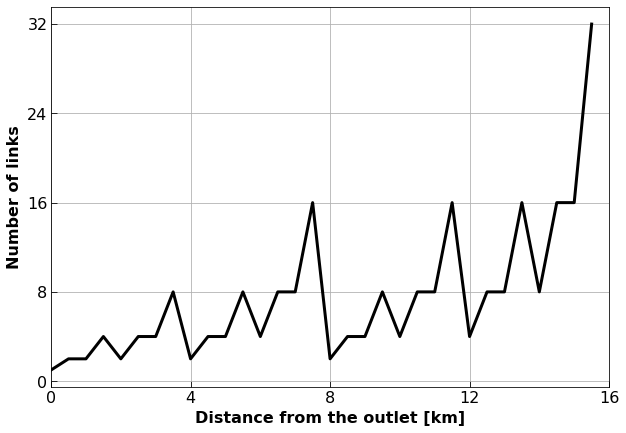

In [42]:
from hlm_basic.ssn import CalculateWidthFinction
width, count = CalculateWidthFinction(connectivity, 0.5)
plt.subplots(figsize=(10, 7))
plt.plot(np.unique(width), count, c='k')
plt.xlim([0,16])
plt.xticks(np.arange(0, 17, 4))
plt.yticks(np.arange(0, max(count)+1,8))
plt.grid(which='both')
plt.xlabel('Distance from the outlet [km]')
plt.ylabel('Number of links')
plt.savefig('../data/supplement/WidthFunction_Order6.png',bbox_inches = 'tight', pad_inches = 0.5)
plt.show()

In [16]:
def GenerateRainfall(sim_hours):
    days = int(sim_hours / 24)
    forcing_hour = []
    forcing_model = []
    np.random.seed(88)
    for day in range(days):
        if day in np.arange(0, 12, 3):
            occurence = np.random.randint(low=0,high=2,size=24)
            temp = np.random.uniform(0,10,size=24)
            rain = temp * occurence
        elif day == 25:
            occurence = np.random.randint(low=0,high=2,size=24)#np.array([0 for _ in range(24)])#
            # occurence[0] = 1
            temp  = np.random.uniform(0,100,size=24)#np.array([0 for _ in range(24)])#
            # temp[0] = 150
            rain = temp * occurence
            multiplier = np.sum(rain) / 150
            rain  = rain / multiplier
        else:
            rain = np.random.randint(low=0.0,high=1,size=24).astype(float)
        forcing_hour.extend(list(rain))
        forcing_model.extend(list(np.repeat(rain, 60)))
    return forcing_model, forcing_hour

In [17]:
forcing, forcing_hourly = GenerateRainfall(816)
te = len(forcing)-1
cum_forcing = np.repeat(np.cumsum(forcing_hourly), 60)

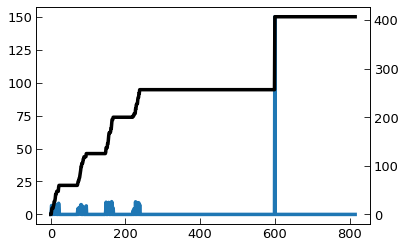

In [31]:
plt.plot(range(len(forcing_hourly)), forcing_hourly)
plt.twinx()
plt.plot(range(len(forcing_hourly)),np.cumsum(forcing_hourly), c='k')

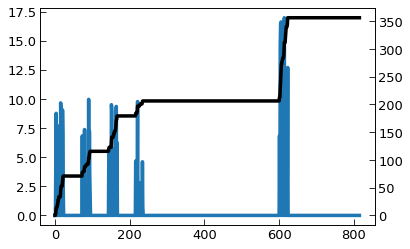

In [18]:
plt.plot(range(len(forcing_hourly)), forcing_hourly)
plt.twinx()
plt.plot(range(len(forcing_hourly)),np.cumsum(forcing_hourly), c='k')


In [27]:
dams = [117, 126] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108, 107]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.9 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(6)
        H_max.append(7)
        diam.append(0.5)
        S_max.append(300000)
        L_spill.append(3.0)
        L_crest.append(10.0)
    elif dam in order_4:
        H_spill.append(6)
        H_max.append(7)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(3.0)
        L_crest.append(10.0)

In [11]:
diam

[0.5, 0.5]

In [20]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-6,)

Model 254 is being used!
48959

In [28]:
SSN3 = Watershed(Model=256)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(5, A_i[0], A_i)
S = [100 for _ in range(n_dams)]
SSN3.set_dam_state(states=[1 for _ in range(n_dams)])
SSN3.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive, st_passive = SSN3.Run_256( [0, te], forcing, dam_params256)
out_passive = SSN3.CalculateOutflow(dam_params256, st_passive)

Model 256 (254 with_dams) is being used!
48959

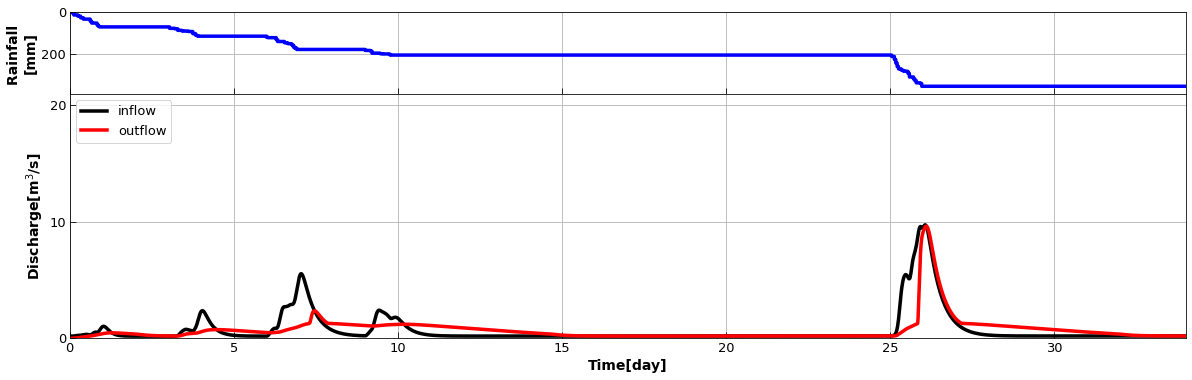

In [29]:
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A', 'linewidth':1}, {'label':'inflow', 'color':'#000000',}, {'label':'outflow', 'color':'r',}])
pltKwargs = pltkwargs[[1,2]]
dataset = [dc_passive, out_passive]
plot_sim(117, cum_forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,21,10])



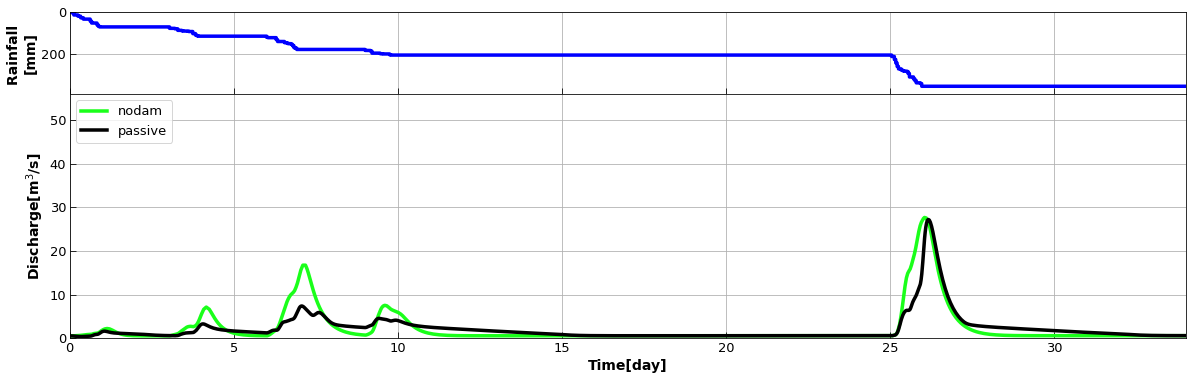

In [30]:
pltkwargs = np.array([{'label':'nodam', 'color':'#1AFF1A', }, {'label':'passive', 'color':'#000000',}, {'label':'outflow', 'color':'r',}])
pltKwargs = pltkwargs[[0,1]]
dataset = [dc_nodam, dc_passive]
plot_sim(108, cum_forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,56,10])

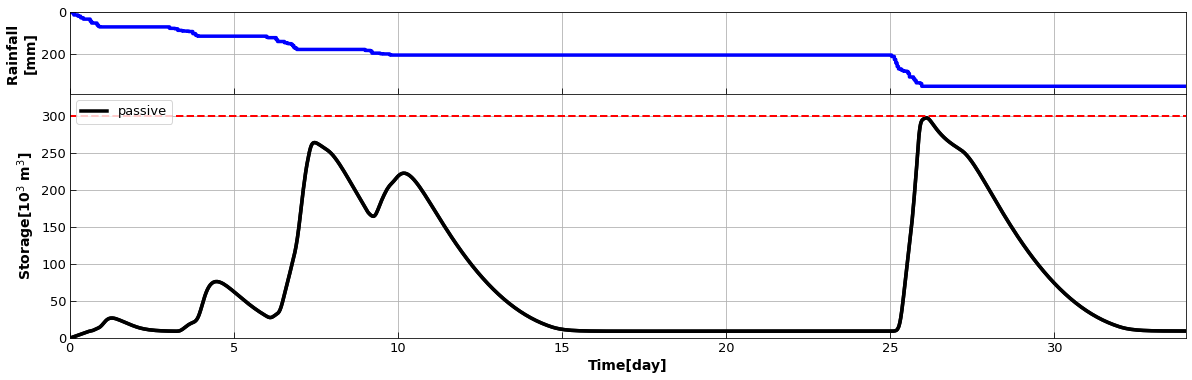

In [31]:
pltKwargs = pltkwargs[[1]]
dataset = [st_passive]
plot_sim(dams, cum_forcing, dataset, pltKwargs, d_type='storage', max_storage=300000)